In [1]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'fuzzywuzzy'

In [33]:
df_movies = pd.read_csv(
    "data/ml-latest/movies.csv",
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    "data/ml-latest/ratings.csv",
    nrows=1000000,
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [34]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int32 
 1   title    58098 non-null  object
dtypes: int32(1), object(1)
memory usage: 681.0+ KB


In [35]:
df_movies.head()

movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)

In [38]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   userId   1000000 non-null  int32  
 1   movieId  1000000 non-null  int32  
 2   rating   1000000 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 11.4 MB


In [39]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])

In [40]:
df_ratings_cnt_tmp

count
rating        
0.5      18425
1.0      31493
1.5      15778
2.0      67075
2.5      48248
3.0     199844
3.5     122020
4.0     265856
4.5      86170
5.0     145091

In [41]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 10073 unique users and 22031 unique movies in this data set


In [42]:
def addZero(rating_zero_cnt):
    # append counts of zero rating to df_ratings_cnt
    return df_ratings_cnt_tmp.append(
        pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
        verify_integrity=True,
    ).sort_index()

In [43]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
df_ratings_cnt = addZero(rating_zero_cnt)

/tmp/ipykernel_18941/581052938.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df_ratings_cnt_tmp.append(


In [44]:
## We add zero score
df_ratings_cnt

count
0.0  220918263
0.5      18425
1.0      31493
1.5      15778
2.0      67075
2.5      48248
3.0     199844
3.5     122020
4.0     265856
4.5      86170
5.0     145091

In [45]:
# The count for zero rating score is too big to compare with others. 
# So let's take log transform for count values and then we can plot them to compare

In [46]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

count  log_count
0.0  220918263  19.213303
0.5      18425   9.821464
1.0      31493  10.357521
1.5      15778   9.666372
2.0      67075  11.113567
2.5      48248  10.784110
3.0     199844  12.205292
3.5     122020  11.711940
4.0     265856  12.490710
4.5      86170  11.364077
5.0     145091  11.885116

Text(0, 0.5, 'number of ratings')

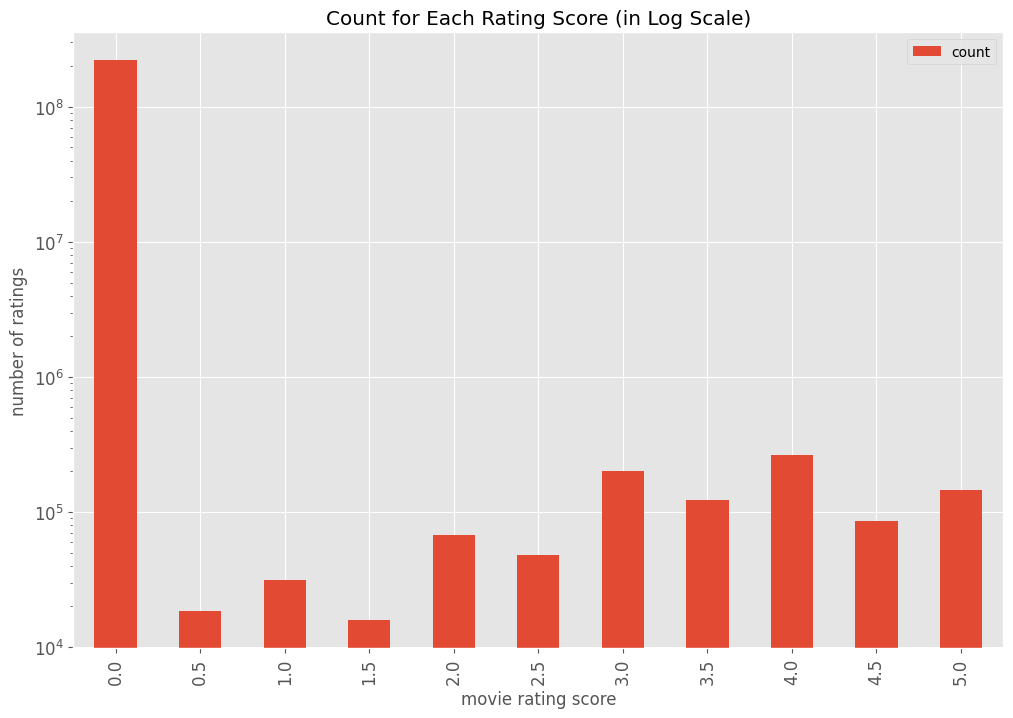

In [47]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [48]:
df_ratings.head()

userId  movieId  rating
0       1      307     3.5
1       1      481     3.5
2       1     1091     1.5
3       1     1257     4.5
4       1     1449     4.5

In [49]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

count
movieId       
1         2469
2          975
3          591
4          122
5          547

Text(0, 0.5, 'number of ratings')

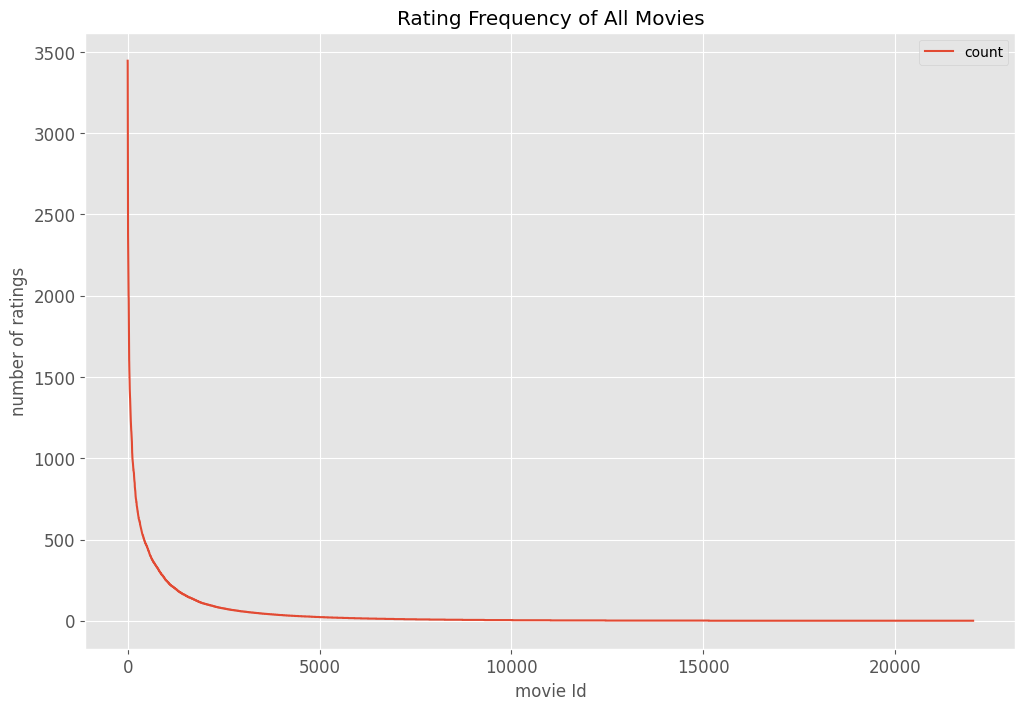

In [50]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

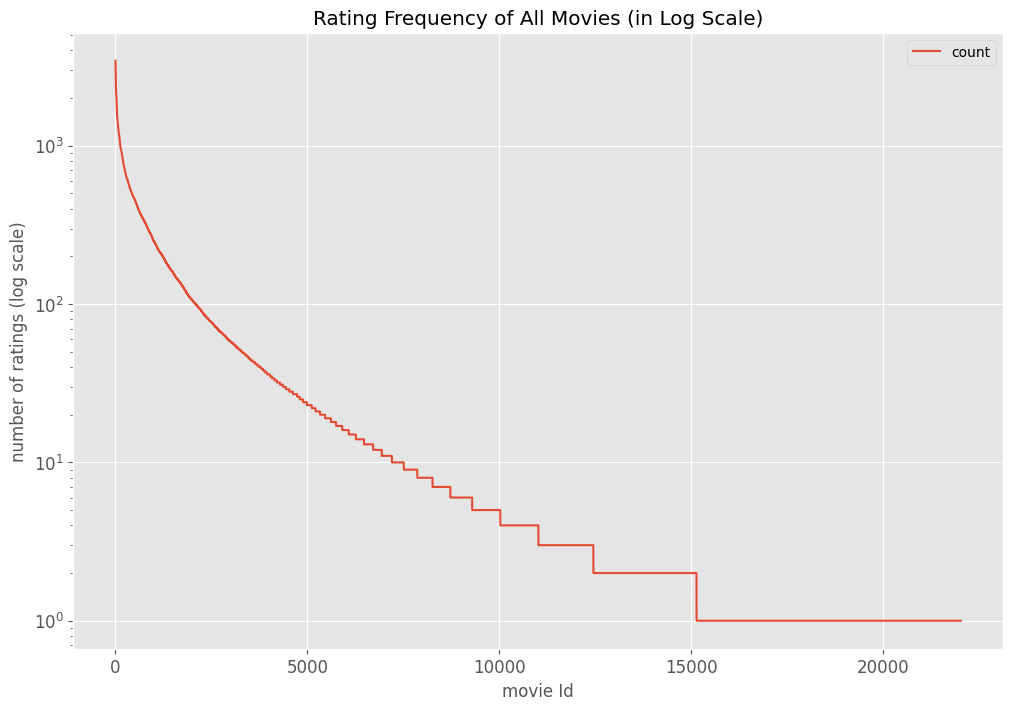

In [51]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [52]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    3446.0
0.95     223.0
0.90      93.0
0.85      50.0
0.80      30.0
0.75      19.0
0.70      13.0
0.65       9.0
Name: count, dtype: float64

In [53]:
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (1000000, 3)
shape of ratings data after dropping unpopular movies:  (866753, 3)


In [54]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

count
userId       
1          16
2          15
3           6
4         688
5          68

Text(0, 0.5, 'number of ratings')

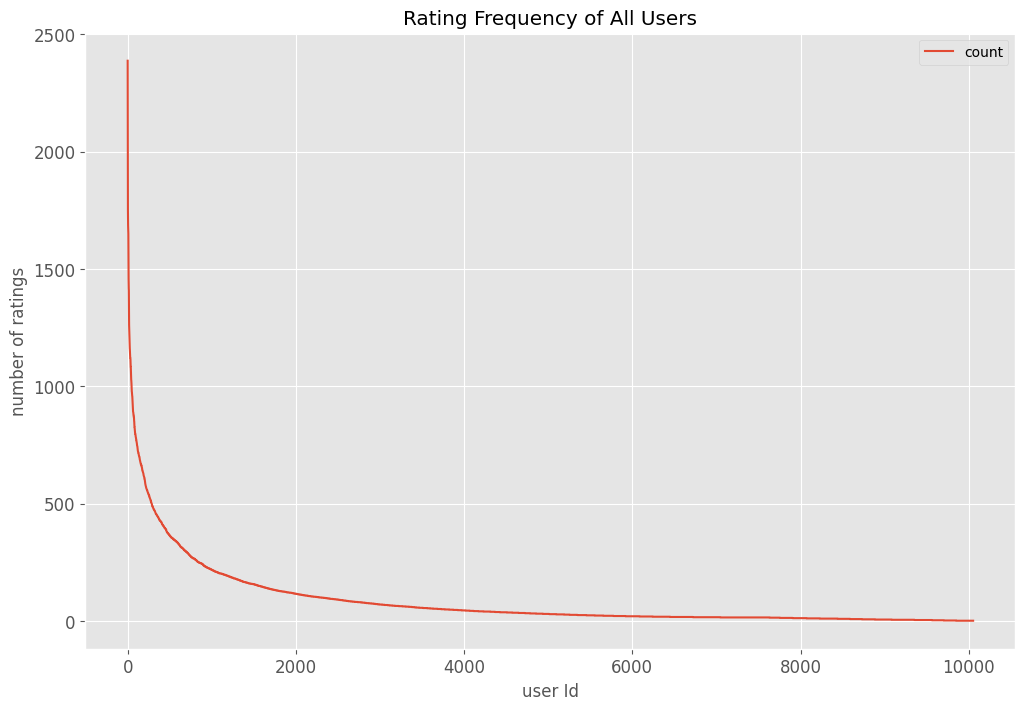

In [55]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [56]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    2387.00
0.95     362.45
0.90     217.00
0.85     155.35
0.80     115.00
0.75      90.00
0.70      70.00
0.65      55.00
0.60      44.00
0.55      36.00
Name: count, dtype: float64

In [57]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users
)

shape of original ratings data:  (1000000, 3)
shape of ratings data after dropping both unpopular movies and inactive users:          userId  movieId  rating
42           4        1     4.0
43           4        2     4.0
44           4        5     2.0
45           4        6     4.5
46           4       10     4.0
...        ...      ...     ...
999995   10073     1370     3.5
999996   10073     1377     3.5
999997   10073     1407     3.0
999998   10073     1466     4.0
999999   10073     1479     3.0

[750501 rows x 3 columns]


In [58]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [59]:
from sklearn.neighbors import NearestNeighbors

In [60]:

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [61]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [62]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [63]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man


NameError: name 'fuzz' is not defined